# Dimension Reduction Samples

# 1. import packages

In [1]:
from src.dimension_reduction.tsne import tSNE
from src.dimension_reduction.pca import PCA
from src.utils import read_image

import os
import random
from tqdm import tqdm

import torchvision
import torch
from torch.utils.data import DataLoader, random_split

from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np

/opt/conda/envs/food_cls/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Define CNN Model

In [2]:
# if you alreay have model to process, pass the train process
if os.path.exists('sample_model.pt'):
    model = torch.load('sample_model.pt')
else:
    model = torchvision.models.resnet18(pretrained=True)
    model.fc = torch.nn.Linear(
        in_features=model.fc.in_features,
        out_features=10,
    )

# 3. Prepare Data

## 3.1 define transform using torchvision

In [3]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize([256, 256]),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [4]:
train_data = torchvision.datasets.CIFAR10('data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.CIFAR10('data', train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_data, val_data = random_split(train_data, [45000, 5000])

In [6]:
train_loader = DataLoader(
    dataset=train_data,
    batch_size=256,
    shuffle=True,
)
val_loader = DataLoader(
    dataset=val_data,
    batch_size=256,
    shuffle=True,
)

# 4. train model

## 4.1 hyperparameters

In [12]:

device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 1
learning_rate = 0.01
log_interval = 10
batch_size = 256
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 2, 0.5)

## 4.2 train model

In [15]:
model.to(device)

for epoch in range(epochs):

    # train loop
    model.train()
    train_loss = 0
    train_matches = 0

    for idx, train_batch in enumerate(train_loader):
        inputs, labels = train_batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outs = model(inputs)
        preds = torch.argmax(outs, dim=-1)
        loss = criterion(outs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_matches += (preds == labels).sum().item()
        if (idx + 1) % log_interval == 0:
            train_loss = train_loss / log_interval
            train_acc = train_matches / batch_size / log_interval
            print(
                f"Epoch[{epoch}/{epochs}]({idx + 1}/{len(train_loader)}) || "
                f"training loss {train_loss:4.2} || training accuracy {train_acc:4.2%} ||"
            )

            train_loss = 0
            train_matches = 0
    
    scheduler.step()

    # val loop
    with torch.no_grad():
        model.eval()
        val_loss = 0
        val_matches = 0

        for val_batch in val_loader:
            inputs, labels = val_batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            outs = model(inputs)
            preds = torch.argmax(outs, dim=-1)

            loss = criterion(outs, labels)

            val_loss += loss.item()
            val_matches += (preds == labels).sum().item()

        val_loss = val_loss / (len(val_loader) * batch_size)
        val_acc = val_matches / (len(val_loader) * batch_size)
            
        print(
            f"current val acc : {val_acc:4.2%}, loss: {val_loss:4.2} || "
        )

Epoch[0/1](10/176) || training loss  3.5 || training accuracy 52.11% ||
Epoch[0/1](20/176) || training loss  3.4 || training accuracy 56.76% ||
Epoch[0/1](30/176) || training loss  3.2 || training accuracy 61.60% ||
Epoch[0/1](40/176) || training loss  3.1 || training accuracy 65.12% ||
Epoch[0/1](50/176) || training loss  3.0 || training accuracy 67.30% ||
Epoch[0/1](60/176) || training loss  3.0 || training accuracy 69.65% ||
Epoch[0/1](70/176) || training loss  2.9 || training accuracy 70.20% ||
Epoch[0/1](80/176) || training loss  2.8 || training accuracy 73.67% ||
Epoch[0/1](90/176) || training loss  2.7 || training accuracy 75.47% ||
Epoch[0/1](100/176) || training loss  2.6 || training accuracy 75.62% ||
Epoch[0/1](110/176) || training loss  2.6 || training accuracy 78.40% ||
Epoch[0/1](120/176) || training loss  2.5 || training accuracy 79.14% ||
Epoch[0/1](130/176) || training loss  2.4 || training accuracy 81.05% ||
Epoch[0/1](140/176) || training loss  2.3 || training accura

In [16]:
torch.save(model, 'sample_model.pt')

# 5. t-SNE

## 5.1 extract feature from model

### 5.1.1 remove fc layer of model

In [17]:
model.fc = torch.nn.Identity()

### 5.1.2 prepare test data to visualize

In [18]:
test_loader = DataLoader(
    dataset=test_data,
    batch_size = 32,
    shuffle=False,
)

### 5.1.3 define label names for plot (optional)

In [19]:
label_names = test_data.classes
label_names = {i:label_names[i] for i in range(len(label_names))}
label_names

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

### 5.1.3 extraction process

In [20]:
model.to(device)
model.eval()

sample_images = []
labels = []
features = None

for batch in tqdm(test_loader):
    image, label = batch

    sample_images.extend(image.numpy())
    labels.extend(label.numpy())
    
    # feature extraction
    image = image.to(device)
    feature = model(image).detach().cpu().numpy()
    # features.extend(feature.numpy())

    features = np.concatenate((features, feature)) if features is not None else feature

print(len(sample_images), len(labels), len(features))

100%|██████████| 313/313 [00:29<00:00, 10.60it/s]

10000 10000 10000


## 5.2 define t-SNE wrapper

In [21]:
tsne = tSNE(
    features=features,
    images=sample_images,
    labels=labels,
    label_names=label_names,
)

## 5.3 train t-SNE model

In [22]:
tsne.train_model()

/opt/conda/envs/food_cls/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/envs/food_cls/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


## 5.4 visualize

100%|██████████| 10/10 [00:00<00:00, 301.51it/s]


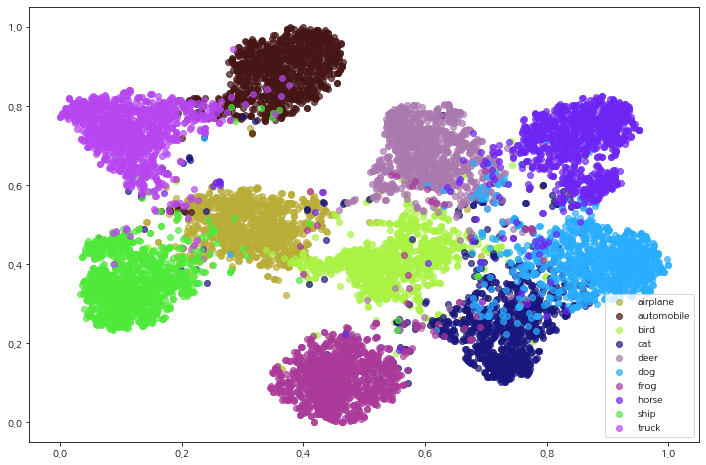

In [23]:
tsne.visualize_tsne_with_point()